### Install required libraries

In [1]:
!pip install cartoframes

    100% |████████████████████████████████| 51kB 2.0MB/s 
    100% |████████████████████████████████| 757kB 4.1MB/s 
    100% |████████████████████████████████| 51kB 12.7MB/s 
    100% |████████████████████████████████| 174kB 5.6MB/s 
    100% |████████████████████████████████| 92kB 9.7MB/s 
    100% |████████████████████████████████| 1.6MB 5.4MB/s 


  Running setup.py bdist_wheel for carto ... - done
  Stored in directory: /content/.cache/pip/wheels/94/d3/27/40abad77cd427d38e4896aec17644470469145ddb7bec26638
  Running setup.py bdist_wheel for backcall ... - done
  Stored in directory: /content/.cache/pip/wheels/98/b0/dd/29e28ff615af3dda4c67cab719dd51357597eabff926976b45
  Running setup.py bdist_wheel for pyrestcli ... - done
  Stored in directory: /content/.cache/pip/wheels/a9/ef/96/c501e9531e92740de3eeb92ae8f865d0cfae6cae16cd33ba6f
  Running setup.py bdist_wheel for future ... - \ | / - done
  Stored in directory: /content/.cache/pip/wheels/11/25/4b/f1c5582c5dc7ace5998bced1042cdf6bfe03983a10ed3f2f2e
Successfully built carto backcall pyrestcli future
  Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0


### Configuration

When you run the follownig cell it appears a button to upload a file with your CARTO credentials. The file needs to have the following structure:


```
[CARTO]
user_name = YOUR_USER_NAME
api_key = YOUR_API_KEY

```

After uploading the file you can continue running the rest of the cells as usual.

In [2]:
from google.colab import files
uploaded = files.upload()

Saving ramiro.conf to ramiro.conf


In [3]:
import configparser
config_filename = uploaded[next(iter(uploaded.keys()))]
config = configparser.ConfigParser(allow_no_value=True)
config.read_string(config_filename.decode('utf-8'))
args = config['CARTO']

print("Working with CARTO user {}.".format(args['user_name']))

Working with CARTO user ramirocartodb.


### Set CARTO credentials

In [0]:
import csv
import pandas as pd
import cartoframes
from cartoframes import Credentials

USERNAME = args['user_name']
APIKEY = args['api_key']
creds = Credentials(username=USERNAME, 
                    key=APIKEY)
cc = cartoframes.CartoContext(creds=creds)

### Get OSM pois

Example of POIs filtered by city using Overpass QL


```
[out:json][timeout:300];
area[name="Madrid"];
(
  node["amenity"="pharmacy"](area);
);
out body;
>;
out skel qt;
```

![osm-pois](URL)

In [0]:
import logging
import json
import requests
import csv
from pathlib import Path

#### Download OSM data

In [0]:
### set varuables

city  = "Madrid"
type  = "amenity"
value = "pharmacy"

In [0]:
### get OSM data as JSON

logger = logging.getLogger(__name__)
logger.info('Downloading from OSM [{}/{}/{}]...'.format(city,type,value))
base_url = 'https://overpass-api.de/api/interpreter'
query ='''
    [out:json][timeout:300];
    area[name="{city}"];
    node(area)["{type}"="{value}"];out qt;
    '''

data = query.format( city = city, type = type, value = value )

r = requests.get(base_url,params = {'data' : data })
if r.status_code != 200:
  raise ValueError('Invalid request to OSM Overpass API for {}/{}/{}'.format(city, type, value))
else:
  json_data = r.json()

In [8]:
### convert JSON to a list and print the total number of rows processed

rows = []

for row in json_data['elements']:
    result = {}
    if 'lat' in row and 'lon' in row:
        result['lat'] = row['lat']
        result['lon'] = row['lon']

        if 'id' in row:
            result['id'] = row['id']

        if 'tags' in row:
            if  'name' in row['tags']:
              result['name'] = row['tags']['name']
              if 'wheelchair' in row['tags']:
                result['wheelchair'] = row['tags']['wheelchair']

        rows.append(result)
        
print('{} rows processed'.format(len(rows)))

1786 rows processed


In [0]:
### write rows in a csv file

with open('pois.csv','w',newline='') as csvfile:
  fieldnames = ['id','lat','lon','name','wheelchair']
  writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
  writer.writeheader()
  writer.writerows(rows)

### Pandas

In [10]:
### convert csv in a pandas dataframe

df = pd.read_csv('pois.csv')

### show first rows
df.head()

,id,lat,lon,name,wheelchair
0,3223656506,40.379016,-3.792758,Farmacia - Paseo de Lanceros 2,NaN
1,3223656495,40.379927,-3.781567,Farmacia - Calle Mirabel 45,NaN
2,3226797176,40.378108,-3.781623,Farmacia - Calle Serradilla 10,NaN
3,3223656481,40.379808,-3.778767,Farmacia - Calle Garrovillas 6,NaN
4,3226796547,40.377619,-3.776078,Farmacia - Calle Aldeanueva de La Vera 19,NaN


In [11]:
### print the df length

len(df)

1786

In [12]:
### count number of non-empty/null values per column

df.count()

id            1786
lat           1786
lon           1786
name          1723
wheelchair      69
dtype: int64

In [13]:
### count number of values per category in wheelchair column

df['wheelchair'].value_counts()

yes        33
no         23
limited    13
Name: wheelchair, dtype: int64

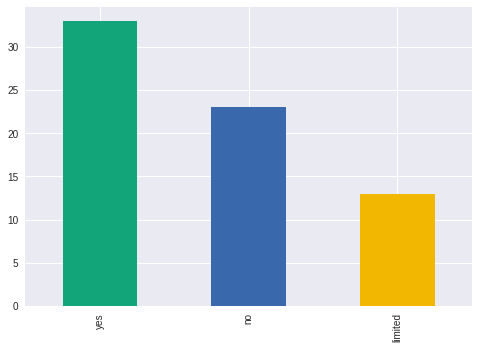

In [14]:
### plot wheelchair histogram

df['wheelchair'].value_counts().plot(kind="bar", color=['#11A579', '#3969AC', '#F2B701'])

### CARTOframes

In [15]:
### import table into carto

table = value + '_table'
cc.write(df, table,
         lnglat=('lon', 'lat'),
         overwrite=True)

/usr/local/lib/python3.6/dist-packages/carto/resources.py:90: FutureWarning: This is part of a non-public CARTO API and may change in the future. Take this into account if you are using this in a production environment
  warnings.warn('This is part of a non-public CARTO API and may change in the future. Take this into account if you are using this in a production environment', FutureWarning)


Table successfully written to CARTO: https://ramirocartodb.carto.com/dataset/pharmacy_table
`the_geom` column is being populated from `('lon', 'lat')`. Check the status of the operation with:
    BatchJobStatus(CartoContext(), 'd9a83b63-adae-4bfa-8b37-ea134740126c').status()
or try reading the table from CARTO in a couple of minutes.
Note: `CartoContext.map` will not work on this table until its geometries are created.


BatchJobStatus(job_id='d9a83b63-adae-4bfa-8b37-ea134740126c', last_status='pending', created_at='2018-05-31T13:31:39.323Z')

In [17]:
from cartoframes import Layer, styling, BaseMap

### define layer
l = Layer(table,
          size=6,
          color={'column': 'wheelchair',
                 'scheme': styling.bold(5)})

### visualize layer
cc.map(layers=l)

In [18]:
### get DO measures available

meta = cc.data_discovery(region=table, keywords='age')
meta.shape

(802, 42)

In [19]:
### get DO measures per data source

meta.groupby('geom_id')['geom_id'].count()

geom_id
es.ine.the_geom    382
eu.geo.nuts2       420
Name: geom_id, dtype: int64

In [20]:
### get INE measures

meta_ine = meta[meta['geom_id'] == 'es.ine.the_geom']
meta_ine.shape

(382, 42)

In [21]:
### list INE measures

meta_ine['numer_name'].values

array(['Population age 60 to 64 (female)',
       'Population age 60 to 64 (female)',
       'Persons with marital status: divorced and under 16 years of age',
       'Persons with marital status: divorced and under 16 years of age',
       'Population age 95 to 99',
       'Females without information regarding their educational level  (under 16 years of age)',
       'Females without information regarding their educational level  (under 16 years of age)',
       'Persons with marital status: single and between 16 (included) and 64 (included) years of age',
       'Persons with marital status: single and between 16 (included) and 64 (included) years of age',
       'Population age 90 to 94', 'Population age 60 to 64',
       'Population age 0 to 4 (female)', 'Population age 0 to 4 (female)',
       'Population age 65 to 69 (female)',
       'Population age 65 to 69 (female)',
       'Persons aged over 64 years and with second level studies',
       'Persons aged over 64 years and with

In [22]:
### add selected population and age measures from DO, buffer with a radius of 200 m
do_measures = ['Population age 75 to 79', 'Population age 80 to 84', 'Population age 85 to 89', 'Population age 90 to 94', 'Population age 95 to 99', 'Population age 100 or more']
meta_selected = meta_ine[meta_ine['numer_name'].isin(do_measures)]
data = cc.data(table, meta_selected)
data.head()

,id,lat,lon,name,pop_100_more_2015,pop_100_more_2015_by_total_pop,pop_75_79_2015,pop_75_79_2015_by_total_pop,pop_80_84_2015,pop_80_84_2015_by_total_pop,pop_85_89_2015,pop_85_89_2015_by_total_pop,pop_90_94_2015,pop_90_94_2015_by_total_pop,pop_95_99_2015,pop_95_99_2015_by_total_pop,the_geom,wheelchair
cartodb_id,,,,,,,,,,,,,,,,,,
1,3223656506,40.379016,-3.792758,Farmacia - Paseo de Lanceros 2,1.0,0.001075,127.0,0.136559,37.0,0.039785,12.0,0.012903,2.0,0.002151,2.0,0.002151,0101000020E610000092239D8191570EC07B12D89C8330...,
2,3223656495,40.379927,-3.781567,Farmacia - Calle Mirabel 45,0.0,0.000000,48.0,0.030000,52.0,0.032500,15.0,0.009375,11.0,0.006875,4.0,0.002500,0101000020E6100000BD169925A6400EC049B02770A130...,
3,3226797176,40.378108,-3.781623,Farmacia - Calle Serradilla 10,0.0,0.000000,55.0,0.073925,18.0,0.024194,5.0,0.006720,5.0,0.006720,2.0,0.002688,0101000020E61000009662A29CC3400EC04F6C4FDA6530...,
4,3223656481,40.379808,-3.778767,Farmacia - Calle Garrovillas 6,1.0,0.001029,40.0,0.041152,37.0,0.038066,10.0,0.010288,3.0,0.003086,2.0,0.002058,0101000020E610000059C345EEE93A0EC0C120448D9D30...,
5,3226796547,40.377619,-3.776078,Farmacia - Calle Aldeanueva de La Vera 19,0.0,0.000000,53.0,0.049533,43.0,0.040187,17.0,0.015888,8.0,0.007477,3.0,0.002804,0101000020E6100000590E999768350EC051EB47D45530...,


In [23]:
### add new field summing all non-normalized variables
data['elderly_ppl'] = data.iloc[:, [4,6,8,10,12,14]].sum(axis=1)
data.head()

,id,lat,lon,name,pop_100_more_2015,pop_100_more_2015_by_total_pop,pop_75_79_2015,pop_75_79_2015_by_total_pop,pop_80_84_2015,pop_80_84_2015_by_total_pop,pop_85_89_2015,pop_85_89_2015_by_total_pop,pop_90_94_2015,pop_90_94_2015_by_total_pop,pop_95_99_2015,pop_95_99_2015_by_total_pop,the_geom,wheelchair,elderly_ppl
cartodb_id,,,,,,,,,,,,,,,,,,,
1,3223656506,40.379016,-3.792758,Farmacia - Paseo de Lanceros 2,1.0,0.001075,127.0,0.136559,37.0,0.039785,12.0,0.012903,2.0,0.002151,2.0,0.002151,0101000020E610000092239D8191570EC07B12D89C8330...,,181.0
2,3223656495,40.379927,-3.781567,Farmacia - Calle Mirabel 45,0.0,0.000000,48.0,0.030000,52.0,0.032500,15.0,0.009375,11.0,0.006875,4.0,0.002500,0101000020E6100000BD169925A6400EC049B02770A130...,,130.0
3,3226797176,40.378108,-3.781623,Farmacia - Calle Serradilla 10,0.0,0.000000,55.0,0.073925,18.0,0.024194,5.0,0.006720,5.0,0.006720,2.0,0.002688,0101000020E61000009662A29CC3400EC04F6C4FDA6530...,,85.0
4,3223656481,40.379808,-3.778767,Farmacia - Calle Garrovillas 6,1.0,0.001029,40.0,0.041152,37.0,0.038066,10.0,0.010288,3.0,0.003086,2.0,0.002058,0101000020E610000059C345EEE93A0EC0C120448D9D30...,,93.0
5,3226796547,40.377619,-3.776078,Farmacia - Calle Aldeanueva de La Vera 19,0.0,0.000000,53.0,0.049533,43.0,0.040187,17.0,0.015888,8.0,0.007477,3.0,0.002804,0101000020E6100000590E999768350EC051EB47D45530...,,124.0


In [24]:
### create new df filtering unnecessary columns
new_data = data.iloc[:, [1,2,3,16,17,18]]
new_data.head()

,lat,lon,name,the_geom,wheelchair,elderly_ppl
cartodb_id,,,,,,
1,40.379016,-3.792758,Farmacia - Paseo de Lanceros 2,0101000020E610000092239D8191570EC07B12D89C8330...,,181.0
2,40.379927,-3.781567,Farmacia - Calle Mirabel 45,0101000020E6100000BD169925A6400EC049B02770A130...,,130.0
3,40.378108,-3.781623,Farmacia - Calle Serradilla 10,0101000020E61000009662A29CC3400EC04F6C4FDA6530...,,85.0
4,40.379808,-3.778767,Farmacia - Calle Garrovillas 6,0101000020E610000059C345EEE93A0EC0C120448D9D30...,,93.0
5,40.377619,-3.776078,Farmacia - Calle Aldeanueva de La Vera 19,0101000020E6100000590E999768350EC051EB47D45530...,,124.0


In [25]:
### import new table with DO measures into CARTO
do_table = 'do_' + table
cc.write(new_data, do_table, overwrite=True)

/usr/local/lib/python3.6/dist-packages/carto/resources.py:90: FutureWarning: This is part of a non-public CARTO API and may change in the future. Take this into account if you are using this in a production environment
  warnings.warn('This is part of a non-public CARTO API and may change in the future. Take this into account if you are using this in a production environment', FutureWarning)


Table successfully written to CARTO: https://ramirocartodb.carto.com/dataset/do_pharmacy_table


In [26]:
## style layer based on the number of elderly people
cc.map(layers=[BaseMap('dark'), 
               Layer(do_table,
               size=6,
               color={'column': 'elderly_ppl',
                      'scheme': styling.sunset(7)})])